In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

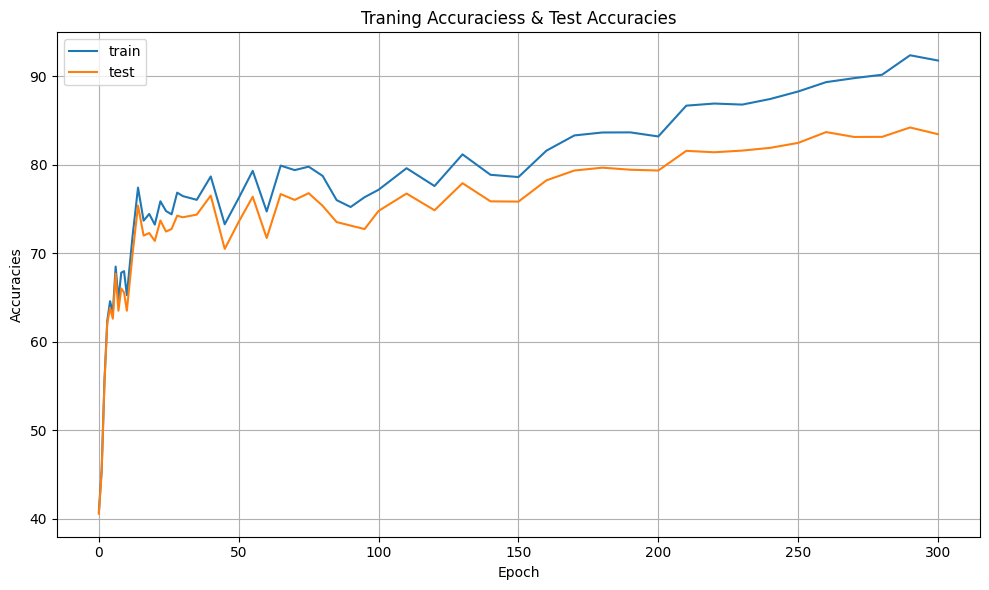

In [2]:
train_accuracies = np.load('train_accuracies.npy')
test_accuracies = np.load('test_accuracies.npy')
epochs = np.load('epochs.npy')
plt.figure(figsize=(10, 6))
sns.lineplot(x=epochs, y=train_accuracies, label='train')
sns.lineplot(x=epochs, y=test_accuracies, label='test')

plt.title('Traning Accuraciess & Test Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracies')

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [3]:
del test_accuracies
del train_accuracies

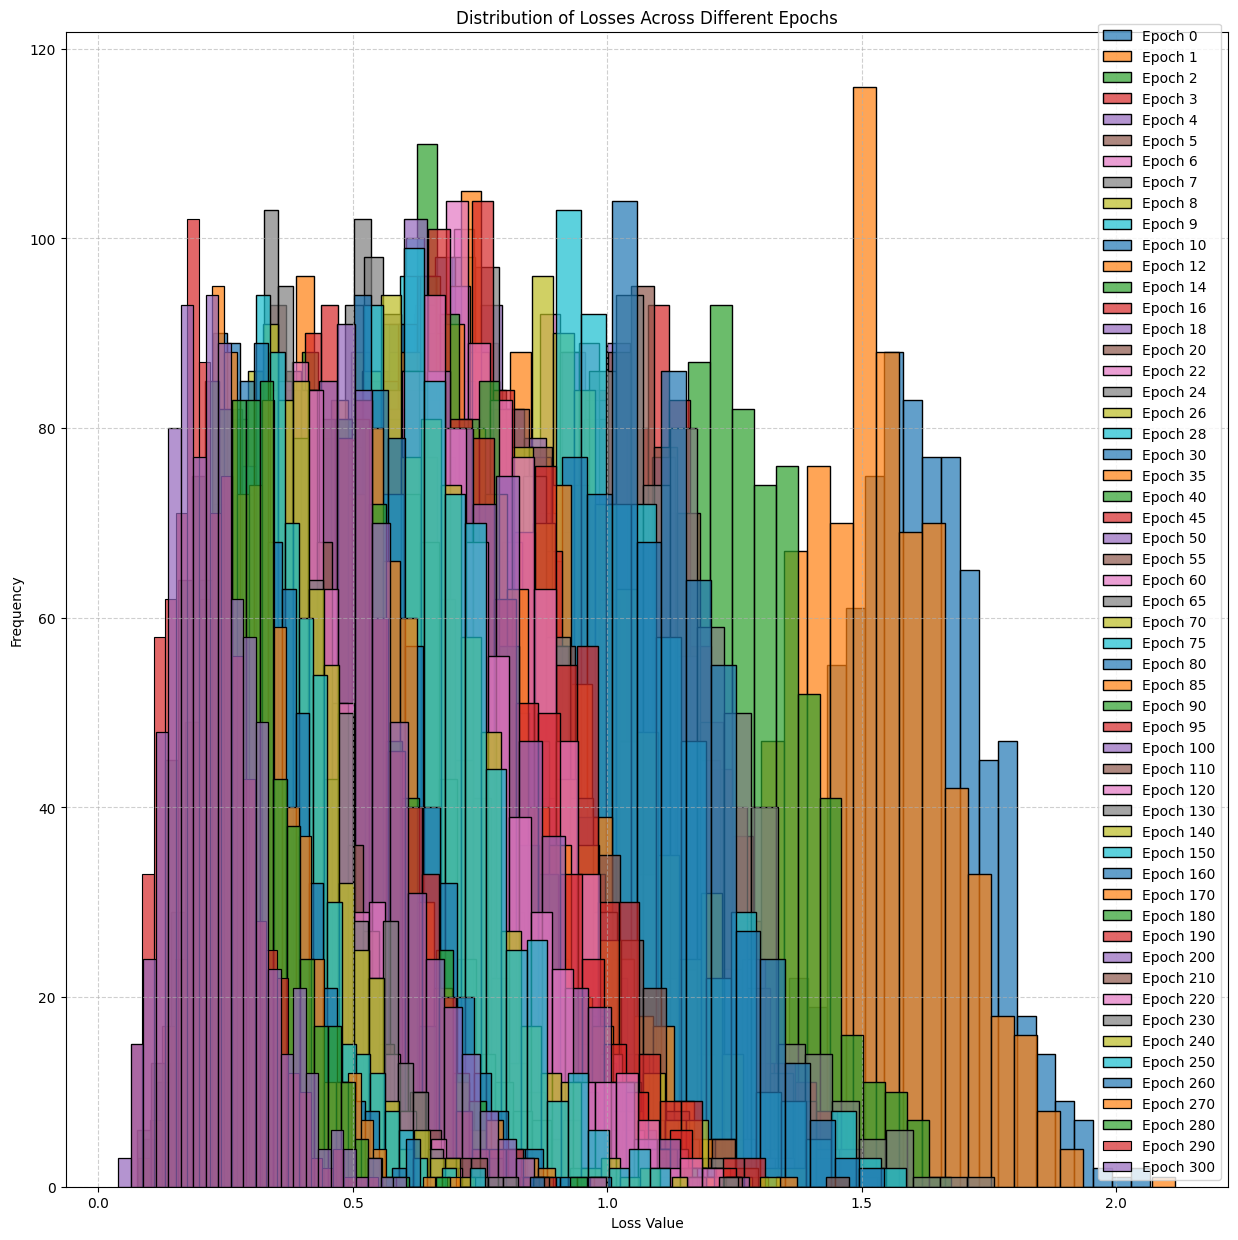

In [4]:
import pickle
with open('all_model_losses.pickle', 'rb') as f: 
	all_model_losses = pickle.load(f)

plt.figure(figsize=(15, 15))
for i in all_model_losses.keys():
	epoch_losses = all_model_losses[i]
	sns.histplot(epoch_losses, kde=False, label=f'Epoch {i}', alpha=0.7)

plt.title('Distribution of Losses Across Different Epochs')
plt.xlabel('Loss Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [5]:
# def plot_distribution_and_contribution(epoch_index, num_bins, ax):
# 	epoch_losses = all_model_losses[epoch_index]
# 	total_loss = sum(epoch_losses)

# 	# Calculate the number of samples in each loss bin for distribution
# 	hist, bin_edges = np.histogram(epoch_losses, bins=num_bins)
# 	bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# 	# Plot the distribution (histogram)
# 	sns.histplot(epoch_losses, bins=num_bins, kde=False, color='skyblue', ax=ax, label='Distribution', alpha=0.6)
# 	ax.set_ylabel('Frequency', color='skyblue')
# 	ax.tick_params(axis='y', labelcolor='skyblue')

# 	# Create a second y-axis for the contributions
# 	ax2 = ax.twinx()

# 	# Calculate the contribution of each bin: loss * number of samples
# 	contributions = bin_centers * hist / total_loss

# 	# Plot the contributions (bar chart)
# 	ax2.bar(bin_centers, contributions, width=(bin_edges[1] - bin_edges[0]) * 0.9, color='lightcoral', edgecolor='black', label='Contribution', alpha=0.7)
# 	ax2.set_ylabel('Contribution (Loss * Frequency)', color='lightcoral')
# 	ax2.tick_params(axis='y', labelcolor='lightcoral')

# 	plt.title(f'Distribution and Contribution of Epoch {epoch_index} Losses')
# 	ax.set_xlabel('Loss Value')
# 	ax.grid(axis='y', linestyle='--', alpha=0.4)
# 	ax2.grid(False) # Disable grid for the second y-axis

# 	# Combine legends from both axes
# 	lines1, labels1 = ax.get_legend_handles_labels()
# 	lines2, labels2 = ax2.get_legend_handles_labels()
# 	ax.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

In [6]:
def _calculate_bin_sum_contributions(epoch_losses, bin_edges, total_loss):
    """
    计算每个 bin 内实际 loss 值的总和，并将其按总 loss 进行归一化。

    参数:
        epoch_losses (np.array 或 list): 当前 epoch 的 loss 值列表或数组。
        bin_edges (np.array): 来自 np.histogram 的 bin 边界。
        total_loss (float): 当前 epoch 的所有 loss 值的总和。

    返回:
        np.array: 归一化后的贡献度 (每个 bin 内实际 loss 总和 / 总 loss)。
    """
    # 初始化一个数组，用于存储每个 bin 内 loss 值的累加和
    bin_sum_losses = np.zeros(len(bin_edges) - 1)

    # 遍历每个 loss，将其累加到正确的 bin 中
    for loss in epoch_losses:
        # np.digitize 返回每个值所属 bin 的索引。
        # 结果是 1-based index，对于等于最后一个 bin 边界的值，返回 len(bin_edges)。
        # 所以需要 -1 转换为 0-based index。
        bin_idx = np.digitize(loss, bin_edges) - 1

        # 确保索引在 bin_sum_losses 的有效范围内
        # 例如，如果 loss 恰好等于最后一个 bin 的上边界，np.digitize 可能返回 len(bin_edges)。
        bin_idx = np.clip(bin_idx, 0, len(bin_sum_losses) - 1)

        bin_sum_losses[bin_idx] += loss

    # 将每个 bin 的累加和除以总 loss 进行归一化
    if total_loss == 0:
        return np.zeros_like(bin_sum_losses)
    else:
        return bin_sum_losses / total_loss


# --- 主绘图函数 ---
def plot_distribution_and_contribution(epoch_index, ax):
    """
    绘制给定 epoch 的 loss 分布 (直方图) 和每个 bin 的实际 loss 贡献度。

    参数:
        epoch_index (int): 要绘制的 epoch 索引。
        num_bins (int): 直方图的 bin 数量。
        ax (matplotlib.axes.Axes): 用于绘图的 Axes 对象。
    """
    # 将 loss 列表转换为 NumPy 数组，方便处理
    epoch_losses = np.array(all_model_losses[epoch_index])
    total_loss = np.sum(epoch_losses) # 使用 np.sum 更安全，处理空数组或全零情况

    # 计算每个 loss bin 中的样本数量，用于分布图
    # hist: 每个 bin 中的样本计数
    # bin_edges: bin 的边界
    hist, bin_edges = np.histogram(epoch_losses)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2 # bin 的中心点，用于条形图定位

    # 绘制分布图 (直方图) 到主 Y 轴 (左侧)
    sns.histplot(epoch_losses, kde=False, color='skyblue', ax=ax, label='Loss Distribution', alpha=0.6)
    ax.set_ylabel('Frequency', color='skyblue')
    ax.tick_params(axis='y', labelcolor='skyblue')

    # 创建第二个 Y 轴，与主轴共享 X 轴 (右侧)
    ax2 = ax.twinx()

    # !!! 调用新的辅助函数计算贡献度 !!!
    contributions = _calculate_bin_sum_contributions(epoch_losses, bin_edges, total_loss)

    # 绘制贡献度 (条形图) 到 ax2
    ax2.bar(bin_centers, contributions, width=(bin_edges[1] - bin_edges[0]) * 0.9, color='lightcoral', edgecolor='black', label='Loss Contribution', alpha=0.7)
    ax2.set_ylabel('Contribution (Loss * Frequency)', color='lightcoral') # 修改标签，更准确
    ax2.tick_params(axis='y', labelcolor='lightcoral')
    # 确保右侧 Y 轴的范围合理，通常贡献度在 0 到 1 之间
    ax2.set_ylim(0, max(contributions) * 1.1 if len(contributions) > 0 and max(contributions) > 0 else 0.1)


    # 设置子图标题和 X 轴标签
    ax.set_title(f'Loss Distribution and Contribution of Epoch {epoch_index} Losses') # 标题显示 epoch 号
    ax.set_xlabel('Loss Value')
    ax.grid(axis='y', linestyle='--', alpha=0.4) # 主轴网格线
    ax2.grid(False) # 禁用第二个 Y 轴的网格线

    # 合并两个轴的图例
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize='small') # 缩小字体防止拥挤


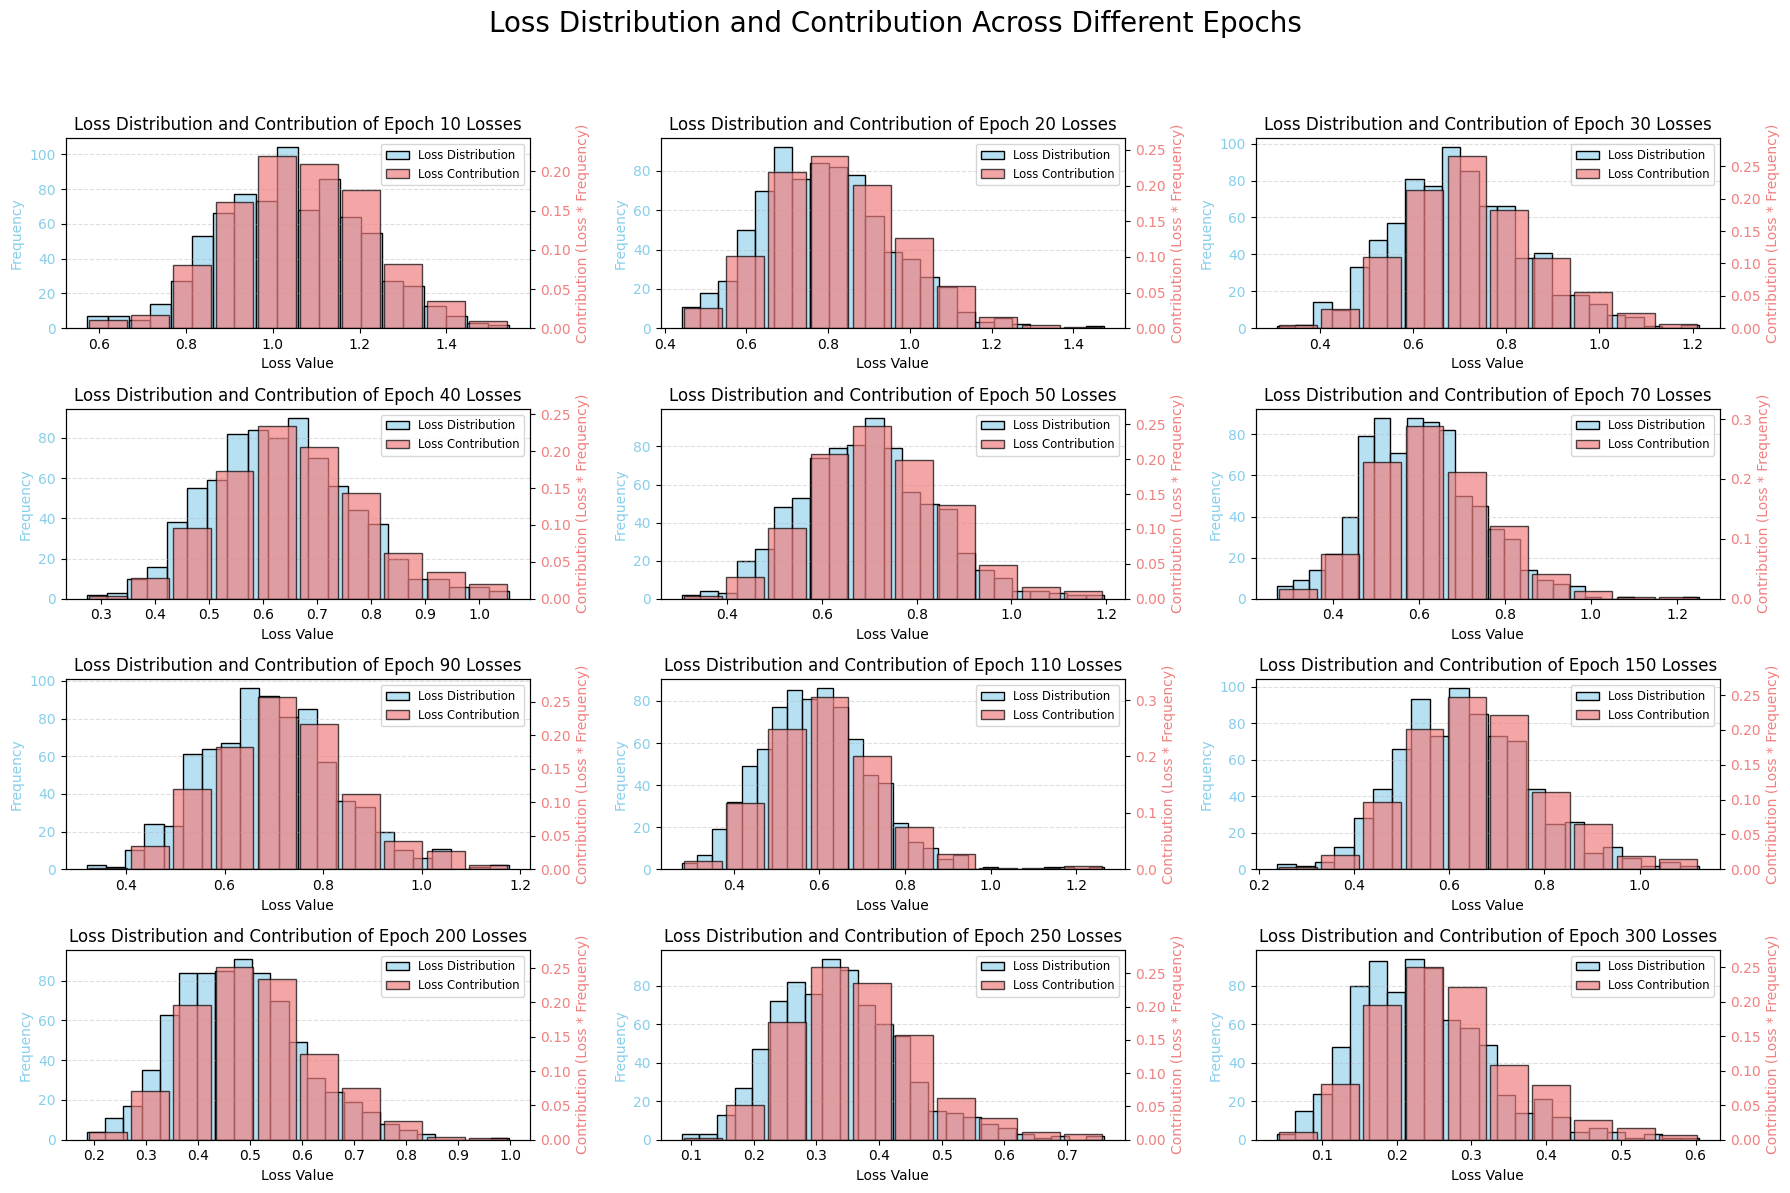

In [7]:
fig, axes = plt.subplots(4, 3, figsize=(18, 12)) # 增加了 figsize
axes_flat = axes.flatten()

epoch_indices_to_plot = [10, 20, 30, 40, 50, 70, 90, 110, 150, 200, 250, 300]

# 遍历 epoch 索引，并将其映射到扁平化的 axes 数组中的每个子图
for i, epoch_index in enumerate(epoch_indices_to_plot):
    plot_distribution_and_contribution(epoch_index, axes_flat[i])

# 设置整个 Figure 的总标题
fig.suptitle('Loss Distribution and Contribution Across Different Epochs', fontsize=20, y=1.02) # y 调整标题位置

plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # 调整布局，为总标题留出空间
plt.show()

<Axes: >

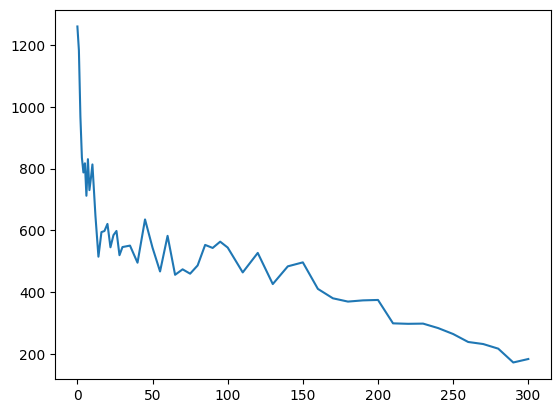

In [8]:
epoch_losses = []
for epoch in epochs:
	epoch_losses.append(np.sum(all_model_losses[epoch]))

sns.lineplot(x=epochs, y=epoch_losses)